# Multi-class Classification

In [2]:
# used for manipulating directory paths
import os
import math
# Scientific and vector computation for python
import numpy as np
# Plotting library
from matplotlib import pyplot
# Optimization module in scipy
from scipy import optimize
# will be used to load MATLAB mat datafile format
from scipy.io import loadmat
%matplotlib inline

Data set in ex3data1.mat contains 5000 training examples of handwritten digits (This is a subset of the MNIST handwritten digit dataset). The .mat format means that that the data has been saved in a native Octave/MATLAB matrix format, instead of a text (ASCII) format like a csv-file. 
Python provides mechanisms to load MATLAB native format using the loadmat function within the scipy.io module. This function returns a python dictionary with keys containing the variable names within the .mat file.
There are 5000 training examples in ex3data1.mat, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.The second part of the training set is a 5000-dimensional vector y that contains labels for the training set.

In [3]:
# 20x20 Input Images of Digits
input_layer_size  = 400
# 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)
num_labels = 10
#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex3data1.mat'))
X, y = data['X'], data['y'].ravel()
# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0
m = y.size

In [4]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')


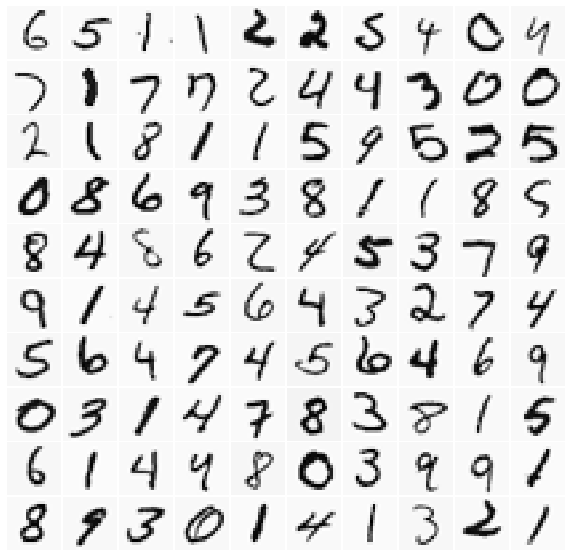

In [5]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]
displayData(sel)

In [6]:
def sigmoid(z):
    f = lambda x: 1/(1+math.exp(-1*x))
    vf = np.vectorize(f)
    z = np.array(z)
    g = np.array(z.shape)
    g = vf(z)
    return(g)
def log(z):
    f = lambda x: math.log(x)
    vf = np.vectorize(f)
    z = np.array(z)
    g = np.array(z.shape)
    g = vf(z)
    return(g)

In [7]:
def lrCostFunction(theta, X, y, lambda_):
    #Initialize some useful values
    m = y.size
    
    # convert labels to ints if their type is bool
    if y.dtype == bool:
        y = y.astype(int)
    temp = theta.copy()
    temp[0] = 0
    J = 0
    grad = np.zeros(theta.shape)
    h = sigmoid(np.dot(X,theta))
    J = np.dot(y.T,log(h)) + np.dot((1 - y.T),log(1-h))
    J = -J / m
    a = temp * temp
    J += (lambda_ * a.sum()) / (2 * m)
    
    grad = (np.dot(X.T,h-y) / m)  + (lambda_/m)*temp
    
    return J,grad

In [8]:
# test values for the parameters theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# test values for the inputs
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)

# test values for the labels
y_t = np.array([1, 0, 1, 0, 1])

# test value for the regularization parameter
lambda_t = 3

In [9]:
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Cost         : {:.6f}'.format(J))
print('Expected cost: 2.534819')
print('-----------------------')
print('Gradients:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Expected gradients:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]');

Cost         : 2.534819
Expected cost: 2.534819
-----------------------
Gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]
Expected gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]


In [10]:
def oneVsAll(X, y, num_labels, lambda_):
    '''
    Trains num_labels logistic regression classifiers and returns
    each of these classifiers in a matrix all_theta, where the i-th
    row of all_theta corresponds to the classifier for label i.
    '''
    m, n = X.shape
    all_theta = np.zeros((num_labels, n + 1))
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    for i in range(num_labels):
        init_theta = np.zeros((n+1,1))
        options= {'maxiter': 50}
        res = optimize.minimize(lrCostFunction,init_theta,(X,y == i,lambda_),jac=True,method='TNC',options=options)
        theta = res.x 
        all_theta[i] = np.transpose(theta)
    return all_theta    

In [11]:
def predictOneVsAll(all_theta,X):
    '''
    Return a vector of predictions for each example in the matrix X. 
    Note that X contains the examples in rows. all_theta is a matrix where
    the i-th row is a trained logistic regression theta vector for the 
    i-th class. You should set p to a vector of values from 0..K-1 
    (e.g., p = [0, 2, 0, 1] predicts classes 0, 2, 0, 1 for 4 examples) .
    '''
    m = X.shape[0];
    num_labels = all_theta.shape[0]
    p = np.zeros(m)
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    for i in range(m):
        temp = np.zeros((num_labels,1))
        for j in range(num_labels):
            temp[j] = np.dot(all_theta[j,:],X[i,:].T)
        p[i] = np.argmax(temp,axis = 0)
    return p    

In [12]:
lambda_ = 0.1
all_theta = oneVsAll(X, y, num_labels, lambda_)
pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy: {:.2f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 95.44%


In [13]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')


Logistic Regression Prediction: 4.0


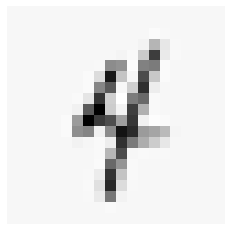

In [19]:
indices = np.random.permutation(m)
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    displayData(X[i, :], figsize=(4, 4))
    print('Logistic Regression Prediction: {}'.format(pred[i]))
else:
    print('No more images to display!')

# Neural Networks Feedforward mechanism

In this part of the exercise, you will implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses. For this week, you will be using parameters from a neural network that we have already trained. Your goal is to implement the feedforward propagation algorithm to use our weights for prediction. In next week’s exercise, you will write the backpropagation algorithm for learning the neural network parameters.

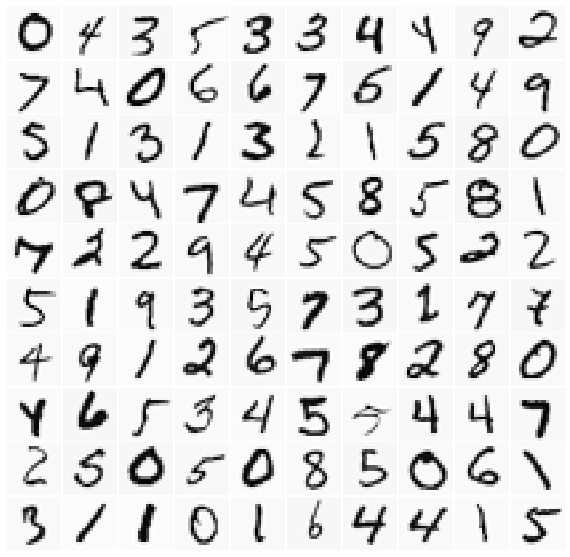

In [15]:
#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex3data1.mat'))
X, y = data['X'], data['y'].ravel()
# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0
# get number of examples in dataset
m = y.size
# randomly permute examples, to be used for visualizing one 
# picture at a time
indices = np.random.permutation(m)
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]
displayData(sel)

Our neural network is shown in the following figure.

![Neural network](Figures/neuralnetwork.png)


In [16]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9
# Load the .mat file, which returns a dictionary 
weights = loadmat(os.path.join('Data', 'ex3weights.mat'))
# get the model weights from the dictionary
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']
# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

In [17]:
def predict(Theta1,Theta2,X):
    # Make sure the input has two dimensions
    if X.ndim == 1:
        X = X[None]  # promote to 2-dimensions
    
    # useful variables
    m = X.shape[0]
    num_labels = Theta2.shape[0]
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    # You need to return the following variables correctly 
    p = np.zeros(X.shape[0])
    for i in range(m):
        a1 = X[i,:].T
        z2 = np.dot(Theta1,a1)
        a2 = sigmoid(z2)
        a2 = np.concatenate(([1],a2),axis = 0)
        z3 = np.dot(Theta2,a2)
        a3 = sigmoid(z3)
        p[i] = np.argmax(a3,axis = 0)
    return p

In [18]:
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: {:.1f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 97.5%


Neural Network Prediction: 7.0


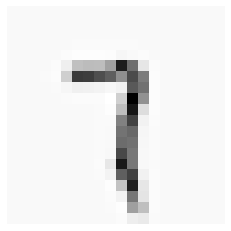

In [19]:
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    displayData(X[i, :], figsize=(4, 4))
    pred = predict(Theta1, Theta2, X[i, :])
    print('Neural Network Prediction: {}'.format(*pred))
else:
    print('No more images to display!')

# Softmax Regression 

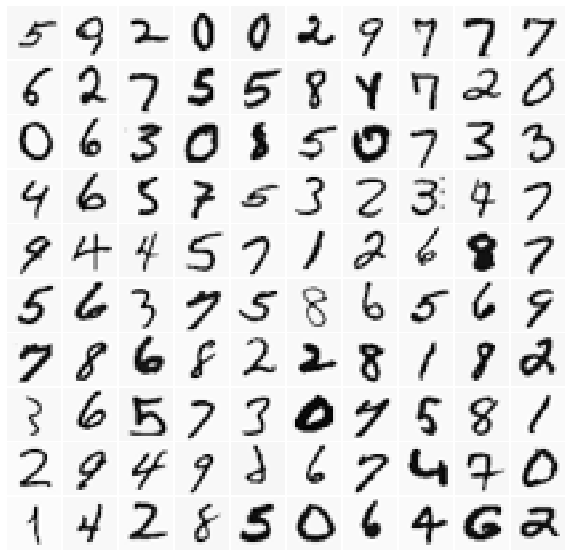

In [20]:
#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex3data1.mat'))
X, y = data['X'], data['y'].ravel()
# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0
# get number of examples in dataset
m = y.size
n = X.shape[1]
# randomly permute examples, to be used for visualizing one 
# picture at a time
indices = np.random.permutation(m)
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]
displayData(sel)

In [21]:
def softmaxCostFunc(theta,X,y):
    m,n = X.shape
    theta = np.reshape(theta,(n,-1))
    print(theta.shape)
    K = theta.shape[1]
    cost = 0
    grad = np.zeros((theta.shape))
    for i in range(m):
        temp = 0
        x = X[i,:].T
        k = y[i]
        for j in range(K):
            temp += math.exp(np.dot(theta[:,j].T,x))
        cost -= math.log(math.exp(np.dot(theta[:,k].T,x)) / temp)
        
    for k in range(K):
        for i in range(m):
            temp = 0
            x = X[i,:].T
            for j in range(K):
                temp += math.exp(np.dot(theta[:,j].T,x))
            if y[i] == k:
                a = 1
            else:
                a = 0
            grad[:,k] -= x * (a - (math.exp(np.dot(theta[:,k].T,x)) / temp))
                            
    grad = np.reshape(grad,(-1,1))
           
    return cost,grad

In [27]:
init_theta = np.zeros((10,X.shape[1]))
options= {'maxiter': 50}
res = optimize.minimize(softmaxCostFunc,init_theta,(X,y),jac=True,method='TNC',options=m)
theta = res.x 

(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)
(400, 10)


In [28]:
def predict(theta,X):
    p = np.argmax(np.dot(X,theta),axis = 0)
    return(p)

In [29]:
def predictAccuracy(theta,X,y):
    m = y.size
    p = np.zeros(m)
    correct = np.zeros(m)
    for i in range(m):
        p[i] = np.argmax(np.dot(X[i,:],theta),axis = 0)
        if p[i] == y[i]:
            correct[i] = 1
    return(correct.sum()/m)
        

In [30]:
theta = np.reshape(theta,(n,10))
print(predictAccuracy(theta,X,y))

0.9518


Softmax Prediction: 1


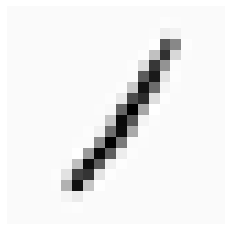

In [235]:
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    displayData(X[i, :], figsize=(4, 4))
    pred = predict(theta,X[i, :])
    print('Softmax Prediction: {}'.format(pred))
else:
    print('No more images to display!')